In [1]:
import os
from disentangle.data_loader.evaluation_dloader import EvaluationDloader
from disentangle.data_loader.patch_index_manager import GridAlignement
from disentangle.nets.model_utils import create_model
from nis2pyr.reader import read_nd2file
from disentangle.config_utils import load_config
import nd2
import glob
import torch
import numpy as np


def load_7D(fpath):    
    print(f'Loading from {fpath}')
    with nd2.ND2File(fpath) as nd2file:
        data = read_nd2file(nd2file)
    return data

def get_best_checkpoint(ckpt_dir):
    output = []
    for filename in glob.glob(ckpt_dir + "/*_best.ckpt"):
        output.append(filename)
    assert len(output) == 1, '\n'.join(output)
    return output[0]

In [2]:
# ckpt_dir = "/group/jug/ashesh/training/disentangle/2407/D28-M3-S0-L0/16"
ckpt_dir = "/group/jug/ashesh/training/disentangle/2407/D28-M3-S0-L0/19"
data_dir = '/facility/imganfacusers/Elisa/DIF17/DIF_17_1'
fnames = [x for x in sorted(os.listdir(data_dir)) if x.endswith('0001.nd2')]

datafile = os.path.join(data_dir, fnames[16])
batch_size = 8

In [3]:
data = load_7D(datafile)
data = data[0,0,:,1,...,0]

Loading from /facility/imganfacusers/Elisa/DIF17/DIF_17_1/DIF_17_Day_25_Untreated_1_4_0001.nd2
ND2 dimensions: {'Z': 21, 'C': 3, 'Y': 3056, 'X': 3056}; RGB: False; datatype: uint16; legacy: False


In [4]:
# fnames:7, [8,1500:2700,500:2200]
# fnames:8, [7/8/9/10,:1400,:800] => good
# fnames:8, [7,1000:2400,800:2200]
# fnames[13], [9/11,900:1500,1000:2400]
# fnames[14], [9,2400:3800,700:2000]
# fnames[15] [9,2200:4500,500:1500]
# fnames[15] [9,300:2400,1000:2800]
# fnames[15] [9,500:2400,2800:3900]
# fnames[15] [9, 2500:4500,600:1500]
# fnames[16] [9,400:1500,500:1700]

In [5]:
config = load_config(ckpt_dir)

In [6]:
test_data= data[8:9].copy()
test_data = test_data.astype(np.float32)
test_data -= config.data.background_values[0]

In [7]:
data.shape

(21, 3056, 3056)

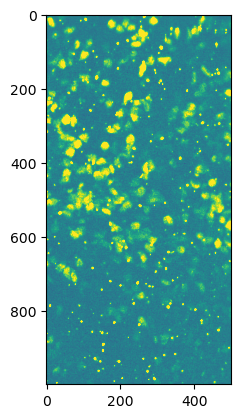

In [8]:
import matplotlib.pyplot as plt
plt.imshow(data[8][1500:2500,1000:1500], vmax=130)

## Mean/Stdev

In [9]:
from disentangle.data_loader.multicrops_dset import l2
def sample_crop(sz):
    t = np.random.randint(0, len(test_data))
    x = np.random.randint(0, test_data.shape[1] - sz)
    y = np.random.randint(0, test_data.shape[2] - sz)
    crop = test_data[t, x:x+sz, y:y+sz]
    return crop

def compute_mean_std():
    mean_inp = []
    std_inp = []
    for _ in range(30000):
        crop = sample_crop(config.data.image_size)
        mean_inp.append(np.mean(crop))
        std_inp.append(np.std(crop))

    output_mean = {}
    output_std = {}
    output_mean['input'] = np.array([np.mean(mean_inp)]).reshape(-1,1,1,1)
    output_std['input'] = np.array([l2(std_inp)]).reshape(-1,1,1,1)
    
    output_mean['target'] = np.tile(output_mean['input'],(1,2,1,1))
    output_std['target'] = np.tile(output_std['input'],(1,2,1,1))
    return output_mean, output_std


In [10]:
mean_dict, std_dict = compute_mean_std()

In [11]:
model = create_model(config, mean_dict.copy(),std_dict.copy())

Noise model Ch1: /home/ashesh.ashesh/training/noise_model/2407/3/GMMNoiseModel_N2V_Elisa-n2v_input__6_4_Clip0.0-1.0_Sig0.125_UpNone_Norm0_bootstrap.npz
Noise model Ch2: /home/ashesh.ashesh/training/noise_model/2407/3/GMMNoiseModel_N2V_Elisa-n2v_input__6_4_Clip0.0-1.0_Sig0.125_UpNone_Norm0_bootstrap.npz
[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[DisentNoiseModel] Nmodels count:2
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[GaussianLikelihood] PredLVar:None LowBLVar:-5
[LadderVAE] 

In [12]:
ckpt_fpath = get_best_checkpoint(ckpt_dir)
print('Loading checkpoint from', ckpt_fpath)
checkpoint = torch.load(ckpt_fpath)

_ = model.load_state_dict(checkpoint['state_dict'], strict=False)
model.eval()
_= model.cuda()
model.set_params_to_same_device_as(torch.Tensor(1).cuda())

print('Loading from epoch', checkpoint['epoch'])

Loading checkpoint from /group/jug/ashesh/training/disentangle/2407/D28-M3-S0-L0/19/BaselineVAECL_best.ckpt
Loading from epoch 44


In [13]:
def normalizer(x):
    return (x - mean_dict['input'].squeeze()) / std_dict['input'].squeeze()

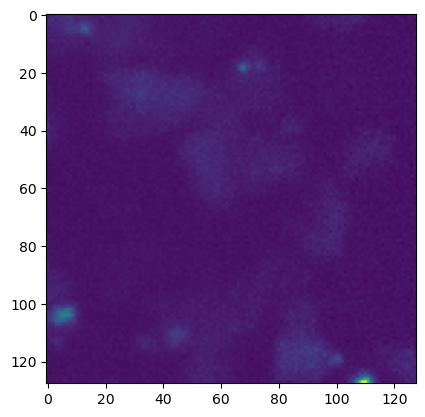

In [14]:
inp_patch = test_data[0,1800:1928,1500:1628]
plt.imshow(inp_patch)

In [15]:
model.reset_for_different_output_size(inp_patch.shape[0])
model.mode_pred = True

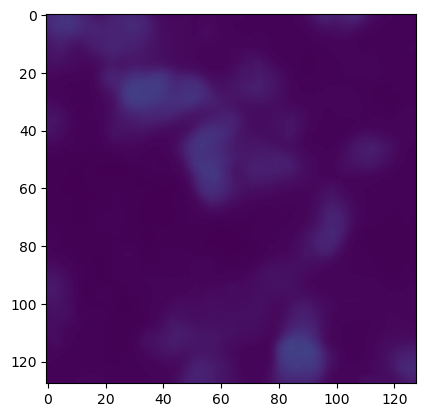

In [16]:
inp = normalizer(inp_patch)
with torch.no_grad():
    out = model(torch.Tensor(inp[None,None]).cuda())
out[0].shape
plt.imshow(out[0][0,1].cpu().numpy(), vmax=30)

In [18]:
dset = EvaluationDloader(test_data[:1], normalizer, lambda x: x, config.data.image_size, config.data.image_size//2, GridAlignement.LeftTop)

In [19]:
from torch.utils.data import DataLoader
from tqdm import tqdm

def get_dset_predictions(model, dset, batch_size, mmse_count=1, num_workers=4):
    model.reset_for_different_output_size(dset[0].shape[0])
    
    dloader = DataLoader(dset, pin_memory=False, num_workers=num_workers, shuffle=False, batch_size=batch_size)
    predictions = []
    predictions_std = []
    with torch.no_grad():
        for inp in tqdm(dloader):
            inp = inp.cuda()
            recon_img_list = []
            for mmse_idx in range(mmse_count):
                imgs, _ = model(inp)
                recon_img_list.append(imgs.cpu()[None])

            samples = torch.cat(recon_img_list, dim=0)
            mmse_imgs = torch.mean(samples, dim=0)
            mmse_std = torch.std(samples, dim=0)
            predictions.append(mmse_imgs.cpu().numpy())
            predictions_std.append(mmse_std.cpu().numpy())
    return np.concatenate(predictions, axis=0), np.concatenate(predictions_std, axis=0)


In [20]:
pred_tiled, pred_std = get_dset_predictions(model, dset, batch_size*10, mmse_count=10, num_workers=4)

  0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


In [21]:
from disentangle.analysis.stitch_prediction import stitch_predictions
pred = stitch_predictions(pred_tiled,dset)


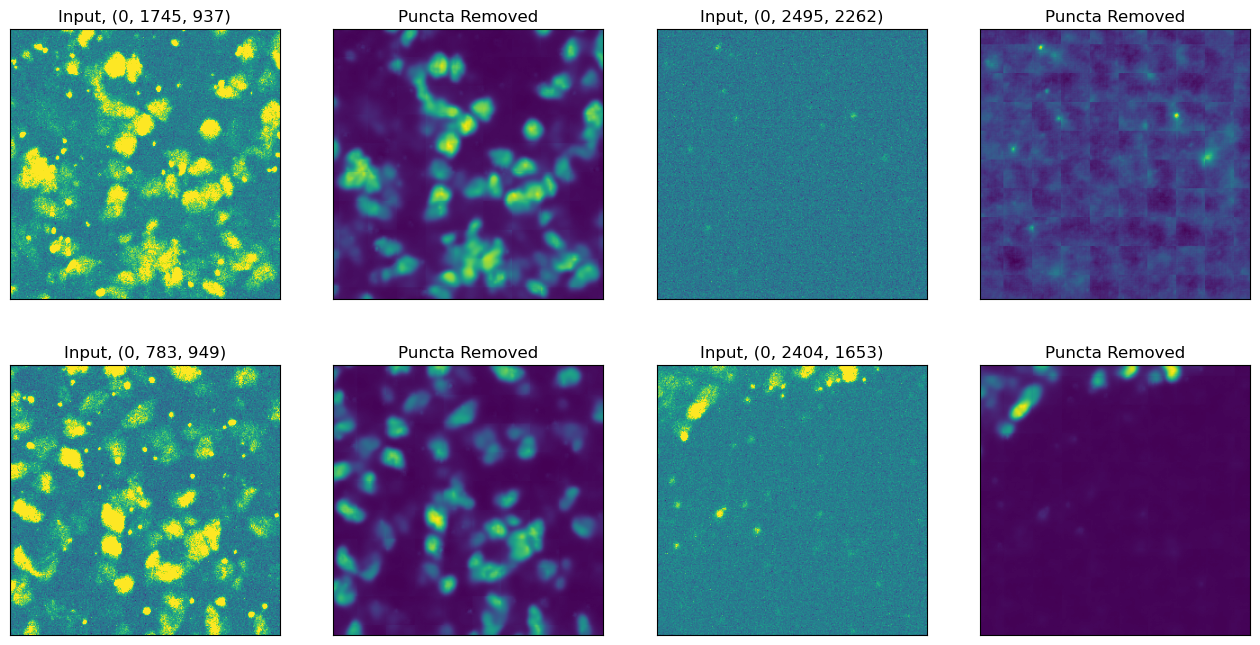

In [25]:
from disentangle.analysis.plot_utils import clean_ax
from matplotlib.colors import LogNorm

_,ax = plt.subplots(figsize=(16,8),ncols=4,nrows=2)
ax= ax.reshape(-1,)
t_idx =0
sz = 300
for i in range(len(ax)//2):
    hs = np.random.randint(0, test_data.shape[1] - sz)
    ws = np.random.randint(0, test_data.shape[2] - sz)
    ax[2*i].imshow(test_data[t_idx,hs:hs+sz,ws:ws+sz], vmax=130)
    ax[2*i+1].imshow(pred[t_idx,hs-16:hs+sz-16,ws-16:ws+sz-16,1])
    ax[2*i].set_title(f'Input, {t_idx,hs,ws}')
    ax[2*i+1].set_title('Puncta Removed')
clean_ax(ax)